# Slice and dice FathomNet
## Oct. 2022
Explore the structure of FathomNet to decide on dataset splits for DUDs paper

In [1]:
import os
import sys
import glob
import datetime
import requests
import json
import progressbar
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.spatial.distance import braycurtis

Load in the benthic concept names for use down the line.

In [2]:
with open('benthic_concepts_pared.txt', 'r') as ff:
    concepts = list(ff)
    ff.close()

concepts = [line.strip() for line in concepts]

## By time
Generate plots by year of localizations

<AxesSubplot:title={'center':'benthic annotations by year'}, xlabel='year', ylabel='count'>

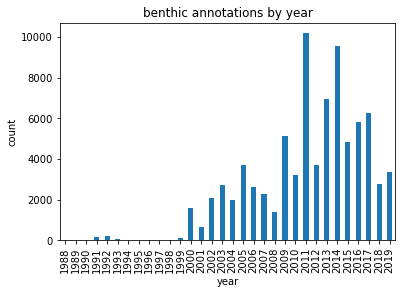

In [3]:
df = pd.read_csv('old/benthic_concepts_per_year.csv', index_col=0)
df.sum(axis=0).plot(kind='bar', title='benthic annotations by year', xlabel='year', ylabel='count')

Per Lonny, annotations at MBARI really picked up post-2000. The shape of this plot is not a FathomNet specific issue; there just aren't that many early annotations from MBARI data. 

Stands to reason that we should focus our efforts just in the past two decades. 

## By concept
Look at the concept distribution of all the data

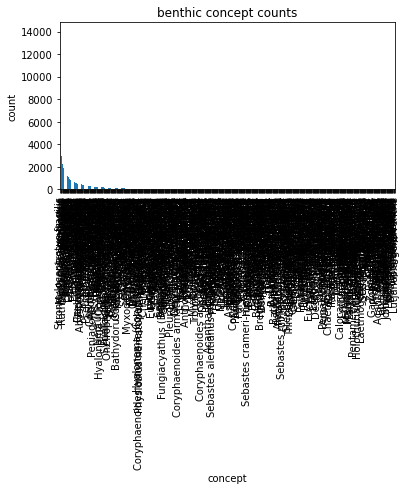

In [4]:
fig, ax = plt.subplots()
df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', 
                                                 title='benthic concept counts', 
                                                 xlabel='concept', 
                                                 ylabel='count', 
                                                 ax=ax)
fig.subplots_adjust(bottom=0.3)

So long-tailed. Now just look at the concepts that have more than 100 localizations.

(110,)


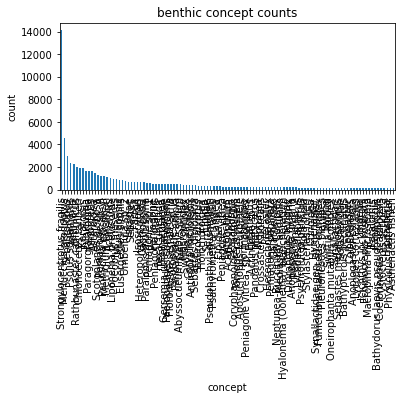

In [66]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 100].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 100].shape)

There are still 110 concepts with more than 100 localizations. Maybe setting 200 as the threshold will be more legible.

(73,)


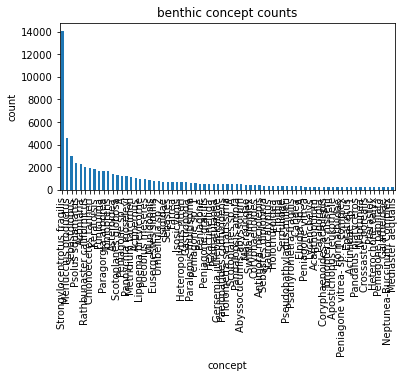

In [5]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 200].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 200].shape)

## By region
Divide the data up by geographic region according to coordinates availabe in the DSG (derived sort of hackily from the [data panel for Nanomia bijuga](http://dsg.mbari.org/dsg/plots/concept/Nanomia%20bijuga/Davidson%20Seamount)). Here are the regions, with `ca_borderland` `max-latitude` adjusted to 35.38 from 37.6 to avoid overlap with `great_mb`:

In [6]:
# this is the format for the command line tool
regions = {'ca_borderland': '--max-latitude 35.38 --min-latitude 32.58 --max-longitude -117.2 --min-longitude -122.7',
           'davidson_seamount': '--max-latitude 35.9 --min-latitude 35.5  --max-longitude -122.5 --min-longitude -122.9',
           'eel_river': '--max-latitude 40.789 --min-latitude 40.07 --max-longitude -124.25 --min-longitude -125.105',
           'great_mb': '--max-latitude 37.199 --min-latitude 35.38 --max-longitude -121.0046 --min-longitude -123.8479',
           'gpg_seamounts': '--max-latitude 37.6 --min-latitude 36.82 --max-longitude -123.15 --min-longitude -123.61',
           'goc': '--max-latitude 32.37 --min-latitude 22.496 --max-longitude -106.498 --min-longitude -116.332',
           'hi': '--max-latitude 23.4 --min-latitude 18.25 --max-longitude -154.2 --min-longitude -161.27',
           'jdf': '--max-latitude 46.16 --min-latitude 44.3 --max-longitude -129.75 --min-longitude -130.67',
           'mars': '--max-latitude 36.714 --min-latitude 36.707 --max-longitude -122.182 --min-longitude -122.192',
           'mb': '--max-latitude 37.0538 --min-latitude 36.4458 --max-longitude -121.7805 --min-longitude -122.5073',
           'pac_nw': '--max-latitude 52.35 --min-latitude 39.7 --max-longitude -123.1 --min-longitude -131.9',
           'rqz_seamount': '--max-latitude 34.19 --min-latitude 33.865 --max-longitude -120.86 --min-longitude -121.26',
           'station_m': '--max-latitude 35.2521 --min-latitude 35.0375 --max-longitude -122.8026 --min-longitude -123.1858',
           'taney_seamount': '--max-latitude 36.95 --min-latitude 36.5 --max-longitude -124.745 --min-longitude -124.945',
           'vance_seamount': '--max-latitude 45.76 --min-latitude 45.155 --max-longitude -130.21 --min-longitude -131.0'
           }

# convert that to dataframe
regions_df = pd.DataFrame(index=regions.keys(), columns=['max-latitude', 'min-latitude', 'max-longitude', 'min-longitude'])

for ii, jj in regions_df.iterrows():
    for j in jj.index.to_list():
        regions_df.at[ii, j] = float(regions[ii].split(j)[1].split(' ')[1])


Some notes regarding regions:
- `mars` is data from around the cabled observatory that MBARI manages. Those coordinates are inside the `mb` region. Worth investigating if those are camera trap images or ones collected by an ROV.
- `station_m` is inside the area described by `ca_borderland`. Worth investigating if those are camera trap images or ones collected by an ROV.
- `mb` is inscribed in `greater_mb`. All images collected in `mb` are also represented in `great_mb`

This next cell can take awhile to run (~11 minutes). The output CSV is saved in this repo for easy access. 

In [13]:
from fathomnet.models import GeoImageConstraints
from fathomnet.api import images, boundingboxes
from tqdm import notebook

inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
df = pd.DataFrame(columns=regions_df.index, index=inds)

# iterate over regions
for ii in notebook.tqdm(df.columns.to_list(), desc='regions'):
    #iterate over concepts  
    for cc in notebook.tqdm(concepts, desc=f'concepts in {ii}', leave=False):
        tmp = GeoImageConstraints(concept=cc,
            maxLatitude=regions_df.at[ii, 'max-latitude'],
            minLatitude=regions_df.at[ii, 'min-latitude'],
            maxLongitude=regions_df.at[ii, 'max-longitude'],
            minLongitude=regions_df.at[ii, 'min-longitude']
        )

        # get the relevant images from region
        imgs = images.find(tmp)

        # get the number of bounding boxes in those images
        numbox = 0
        for im in imgs:
            numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

        # set values in array
        df.loc[(cc, 'images'), ii] = len(imgs)  # number of images with the concept
        df.loc[(cc, 'bboxes'), ii] = numbox  # number of bboxes in those images

# save to this directory
df.sort_index()
df.to_csv('benthic_counts_region.csv')

regions:   0%|          | 0/15 [00:00<?, ?it/s]

concepts in ca_borderland:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in davidson_seamount:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in eel_river:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in great_mb:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in gpg_seamounts:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in goc:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in hi:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in jdf:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in mars:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in mb:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in pac_nw:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in rqz_seamount:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in station_m:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in taney_seamount:   0%|          | 0/620 [00:00<?, ?it/s]

concepts in vance_seamount:   0%|          | 0/620 [00:00<?, ?it/s]

In [71]:
df = df.sort_index()  # sort index if not already

# print the counts of each type in each region and number of concepts
pd.DataFrame((df.xs("images", level="count-type").sum(), 
    df.xs("bboxes", level="count-type").sum(),
    df.xs("bboxes", level="count-type")[df.xs("bboxes", level="count-type") != 0].count()), 
    index=["images","bboxes","num-concepts"]
).T

,images,bboxes,num-concepts
ca_borderland,3118,6734,175
davidson_seamount,1163,1436,117
eel_river,271,669,46
great_mb,30978,59146,446
gpg_seamounts,480,730,68
goc,2924,4258,188
hi,136,145,46
jdf,395,470,51
mars,949,2614,64
mb,20477,44077,347


### Bray-Curtis dissimilarity 
Use [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) (BC) dissimilarity to quantify how different the regions are taxonomically. BC is bounded \[0,1\] with 0 suggesting the regions are taxonomically identical and 1 suggesting there is no species overlap.

Compare `mb` and `ca_borderland` bbox counts with the distance.

In [81]:
# pull out the boudning boxes from the two regions
tmp = df.xs("bboxes", level="count-type")[['ca_borderland', 'mb']]
#tmp = df.xs("bboxes", level="count-type")[['great_mb', 'mb']]
tmp

,ca_borderland,mb
concept,,
Abyssocucumis abyssorum,0,14
Acanthascinae,0,30
Acanthascinae sp. 1-4 complex,3,3
Acanthascinae sp. 2,0,7
Acanthascinae sp. 4,0,0
...,...,...
Ziminella vrijenhoeki,0,2
Zoarcidae,0,5
Zoroaster spinulosus,0,0


Compute [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) by hand and with [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.braycurtis.html) as a sanity check.

In [82]:
# using the wikipedia forumlation
bcwiki = 1 - float(2*tmp[['ca_borderland', 'mb']].min(axis=1).sum())/ \
    float(tmp[['ca_borderland', 'mb']].sum().sum())

# using scipy
bcscipy = braycurtis(tmp['mb'].to_numpy(), tmp['ca_borderland'].to_numpy())

print(f'BC from scipy = {bcscipy}\n\
BC from wikipedia = {bcwiki}', )

BC from scipy = 0.8074432701580366
BC from wikipedia = 0.8074432701580366


Just use the scipy version since it is cleaner. Now compute all BC values pairwise between the regions.

In [103]:
tmp = df.xs("bboxes", level="count-type")
tmp = tmp.drop('taney_seamount', axis=1)  # drop Taney Seamount since there are no labels
outbc = {}

# iterate over regions
for item in tmp.columns:
    try:
        bc = tmp.apply(lambda xx: braycurtis(tmp[item].to_numpy(), xx.to_numpy()), axis=0)
        outbc[item] = bc
    except ZeroDivisionError:
        # catch any regions that have no items
        print(f'no entries in {item}')

outbc = pd.DataFrame(outbc)

Plot as a confusion matrix type deal. Remember that lower numbers indicate regions that are *closer* in terms of taxonomic composition.

In [104]:
outbc.style.background_gradient(cmap='viridis')

,ca_borderland,davidson_seamount,eel_river,great_mb,gpg_seamounts,goc,hi,jdf,mars,mb,pac_nw,rqz_seamount,station_m,vance_seamount
ca_borderland,0.000000,0.895471,0.890315,0.843260,0.908092,0.839884,0.986335,0.941144,0.841677,0.807443,0.765345,0.965271,0.973186,0.996153
davidson_seamount,0.895471,0.000000,0.869834,0.952593,0.656510,0.816649,0.949399,0.776495,0.954074,0.966911,0.746451,0.913826,0.934717,0.971233
eel_river,0.890315,0.869834,0.000000,0.977631,0.802716,0.911102,0.921376,0.863038,0.816631,0.970143,0.596867,0.901015,0.982626,0.979798
great_mb,0.843260,0.952593,0.977631,0.000000,0.975616,0.917198,0.997504,0.986480,0.915350,0.145985,0.918053,0.996288,0.953790,0.999223
gpg_seamounts,0.908092,0.656510,0.802716,0.975616,0.000000,0.901764,0.922286,0.845000,0.927632,0.979557,0.844379,0.797409,0.987219,0.973475
goc,0.839884,0.816649,0.911102,0.917198,0.901764,0.000000,0.971837,0.904822,0.937427,0.922458,0.694557,0.967558,0.909193,0.990659
hi,0.986335,0.949399,0.921376,0.997504,0.922286,0.971837,0.000000,0.921951,0.979703,0.997467,0.960644,0.886364,0.992742,0.928994
jdf,0.941144,0.776495,0.863038,0.986480,0.845000,0.904822,0.921951,0.000000,0.976654,0.982894,0.698718,0.857385,0.978380,0.910931
mars,0.841677,0.954074,0.816631,0.915350,0.927632,0.937427,0.979703,0.976654,0.000000,0.888030,0.774316,0.984632,0.991852,0.994693
mb,0.807443,0.966911,0.970143,0.145985,0.979557,0.922458,0.997467,0.982894,0.888030,0.000000,0.905023,0.995067,0.981719,0.999138


# MB concepts with > 200 locs =  (28,)
# CA Borderlands concepts with > 200 locs =  (18,)


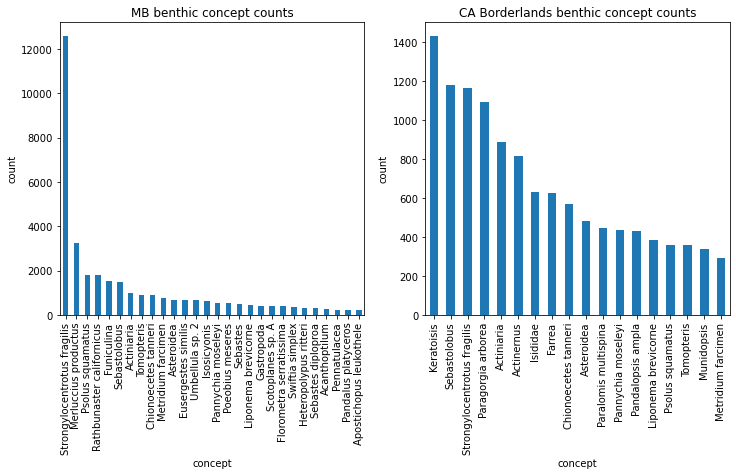

In [41]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
zz = tmp['mb'].sort_values(ascending=False)
zz[zz > 200].plot(kind='bar', 
                  title='MB benthic concept counts', 
                  xlabel='concept', 
                  ylabel='count', 
                  ax=ax[0])

print('# MB concepts with > 200 locs = ', zz[zz > 200].shape)
zz = tmp['ca_border'].sort_values(ascending=False)
zz[zz > 200].plot(kind='bar', 
                  title='CA Borderlands benthic concept counts', 
                  xlabel='concept', 
                  ylabel='count', 
                  ax=ax[1])
fig.subplots_adjust(bottom=0.3)

print('# CA Borderlands concepts with > 200 locs = ', zz[zz > 200].shape)